In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import sys

sys.path.append('/users/local/c23lacro/script/NO_Sentinel/')
from light.Lmodel import NO_model

device = torch.device('cpu')


In [2]:
##################################################################
#       Model
##################################################################

CKPT_PATH = '/users/local/c23lacro/script/NO_Sentinel/experiments/Analysis/NO_conv:FilterConvolution_kernel:[1, 1]_stride:1_skip:None_Res:False_activation:Linearlr:0.0001_batch:4/epoch=973-val_loss=0.00.ckpt'
model = NO_model.load_from_checkpoint(CKPT_PATH).to(device)

checkpoint = torch.load(CKPT_PATH)
#figure name
keys_to_remove = ['lr', 'loss_weights', 'future', 'Q_shape', 'P_shape', 'stride', 'padding']
name = {k: v for k, v in checkpoint['hyper_parameters'].items() if k not in keys_to_remove and v is not None}
model.eval()


No skip connection


NO_model(
  (model): NO(
    (encoder): MLP(
      (fcs): ModuleList(
        (0): Conv2d(20, 512, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (one_step): NO_Block(
      (activation): Identity()
      (convs): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    )
    (decoder): MLP(
      (fcs): ModuleList(
        (0): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
        (1): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
        (2): Conv2d(256, 20, kernel_size=(1, 1), stride=(1, 1))
      )
    )
  )
)

In [3]:
##################################################################
#       Data
##################################################################

path_data = '/users/local/c23lacro/data/Fontainebleau_interpolated_subdomain64.npy'
sentinel_data = np.load(path_data)

if np.max(sentinel_data) > 1:
    sentinel_data /= np.max(sentinel_data)


sentinel_data_diff = sentinel_data[1:,...] - sentinel_data[:-1,...]

sentinel_data = torch.tensor(np.append( sentinel_data[1:,...],sentinel_data_diff, axis=1)).float()

In [4]:
##################################################################
#       Prediction
##################################################################

i_image0 = 0

image0 = sentinel_data[i_image0].unsqueeze(0).to(device)

out,_ = model(image0,sentinel_data.shape[0]-i_image0)
out = out.squeeze(0)


sentinel_data.shape, image0.shape, out.shape



(torch.Size([342, 20, 64, 64]),
 torch.Size([1, 20, 64, 64]),
 torch.Size([342, 20, 64, 64]))

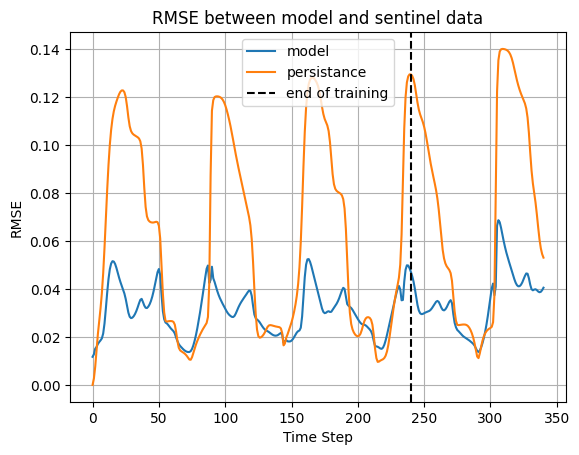

In [16]:
##################################################################
#       Plot
##################################################################
i = slice(0,-1)
plt.plot(
    torch.sqrt(torch.mean((out-sentinel_data)**2, dim = (-3,-2,-1))).detach().cpu().numpy()[i]
    , label = 'model')
plt.plot(
    torch.sqrt(torch.mean((sentinel_data - image0)**2, dim = (-3,-2,-1))).detach().cpu().numpy()[i]
    , label = 'persistance')
plt.title('RMSE between model and sentinel data')

plt.axvline(x=240, color='black', linestyle='--', label = 'end of training')
plt.legend()
#set axis
plt.xlabel('Time Step')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()



In [6]:
torch.mean((out-sentinel_data)**2, dim = (-3,-2,-1)).shape

torch.Size([342])

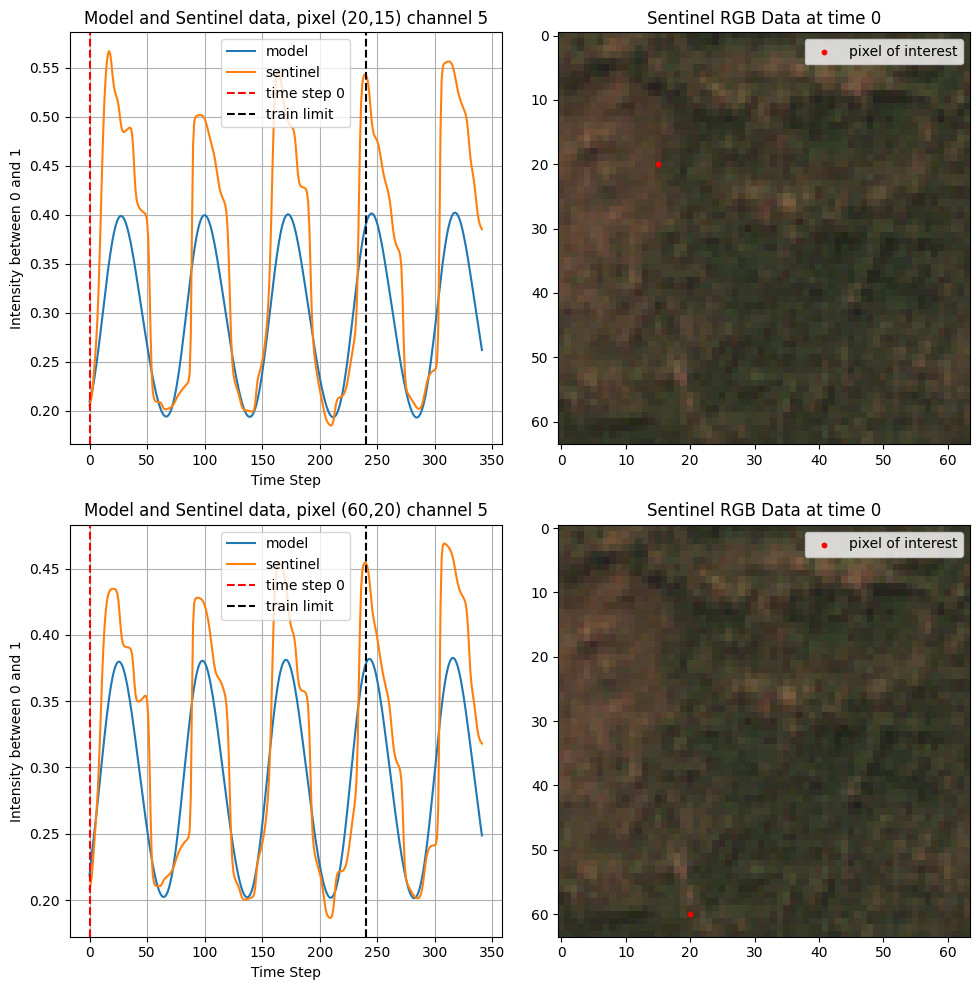

In [15]:
channel = 5
pixx = [20, 60]
pixy = [15, 20]
i_image = 0

fig, axs = plt.subplots(len(pixx), 2, figsize=(10, 5*len(pixx)))

for i in range(len(pixx)):
    # Plot on the first subplot
    axs[i, 0].plot(out[:,channel,pixx[i],pixy[i]].detach().cpu().numpy(), label = 'model')
    axs[i, 0].plot(sentinel_data[:,channel,pixx[i],pixy[i]].detach().cpu().numpy(), label = 'sentinel')
    axs[i, 0].set_title('Model and Sentinel data, pixel ({},{}) channel {}'.format(pixx[i],pixy[i],channel))
    axs[i, 0].legend()
    #set a vertical line at 240
    axs[i, 0].axvline(i_image, color='r', linestyle='--', label = 'time step {}'.format(i_image))
    axs[i, 0].axvline(240, color='black', linestyle='--', label = 'train limit')
    #legend
    axs[i, 0].legend()

    axs[i, 0].grid()


    #set axis
    axs[i, 0].set_xlabel('Time Step')
    axs[i, 0].set_ylabel('Intensity between 0 and 1')  

    # Plot on the second subplot

    axs[i, 1].imshow(sentinel_data[i_image,[2,1,0],:,:].detach().cpu().numpy().transpose(1,2,0)*4)
    axs[i, 1].set_title('Sentinel RGB Data at time {}'.format(i_image))
    axs[i, 1].scatter(pixy[i],pixx[i], c='r', s=10, label = 'pixel of interest')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()


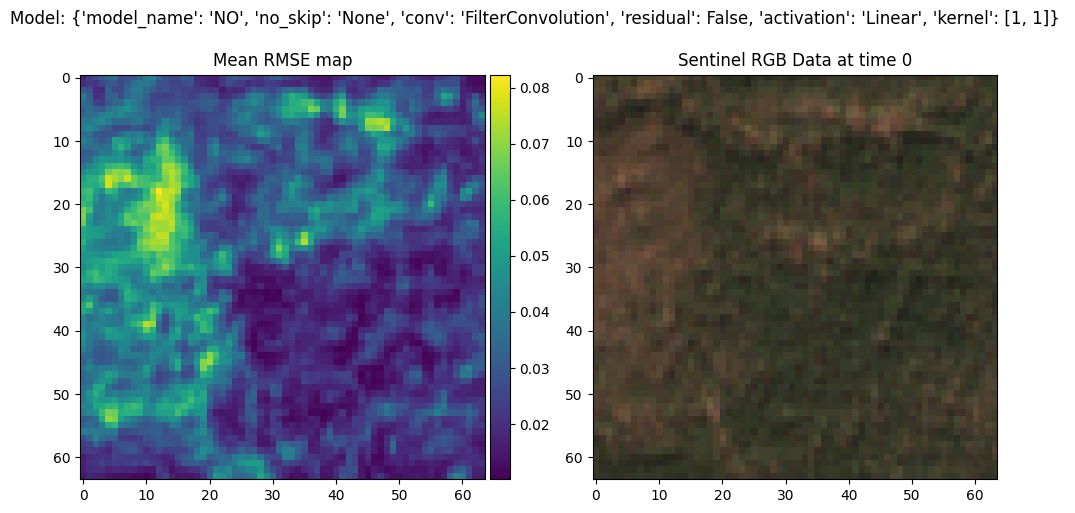

In [8]:
#mean RMSE map on figueraie with sentinel data
fig, axs = plt.subplots(1,2, figsize=(10, 5))
fig.suptitle('Model: {} \n'.format(name))

# Plot on the first subplot
axs[0].imshow(
    torch.sqrt(torch.mean((out-sentinel_data)**2, dim = (0,1 ))
               ).detach().cpu().numpy())
axs[0].set_title('Mean RMSE map')
#colorbar

# Plot on the second subplot
i_image = 0
axs[1].imshow(sentinel_data[i_image,[2,1,0],:,:].detach().cpu().numpy().transpose(1,2,0)*4)
axs[1].set_title('Sentinel RGB Data at time {}'.format(i_image))
maxs = torch.max(torch.max(torch.max(
        sentinel_data, dim = (0)
        ).values, dim = (-1)).values, dim = (-1)).values
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.05)
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(axs[0].imshow(
    torch.sqrt(torch.mean((out-sentinel_data)**2, dim = (0,1 ))).detach().cpu().numpy()
    ), cax = cax1)
cbar2 = plt.colorbar(axs[1].imshow(sentinel_data[i_image,[2,1,0],:,:].detach().cpu().numpy().transpose(1,2,0)*4), cax = cax2)
cbar2.remove()

plt.tight_layout()
plt.show()

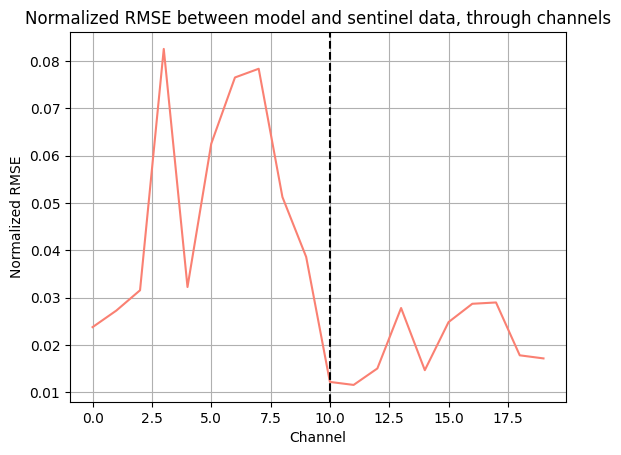

In [13]:
maxs = torch.max(torch.max(torch.max(
        sentinel_data, dim = (0)
        ).values, dim = (-1)).values, dim = (-1)).values

plt.title('Normalized RMSE between model and sentinel data, through channels')
plt.plot(
torch.sqrt((torch.mean((out-sentinel_data)**2, dim = (0,-2,-1 )))/maxs).detach().cpu().numpy()
, color = 'salmon')
#put a vertical line at 10
plt.axvline(x=10, color='black', linestyle='--')
plt.xlabel('Channel')
plt.ylabel('Normalized RMSE')
plt.grid()
plt.show()